In [1]:
import wandb
import re

api = wandb.Api()

project = "rank_masking"
entity = "mallahova"

runs = api.runs(f"{entity}/{project}")

run_max_metrics = []

for run in runs:
    seed = run.config.get("seed", "N/A")
    run_history = run.history()
    rank_metrics = [key for key, value in run_history.items() if re.match(r"eval/rank_\d+_accuracy", key)]
    if rank_metrics:
        max_metric_per_rank = {key: run.history(keys=[key])[key].max()*100 for key in sorted(rank_metrics, key=lambda item: int(re.search(r'\d+', item).group()))}
        overall_max = max(max_metric_per_rank.items(), key=lambda item: item[1])
        run_max_metrics.append({
            "run_name": run.name,
            "seed": seed,
            "max_per_rank": max_metric_per_rank,
            "overall_max": overall_max
        })

for result in run_max_metrics:
    print(f"Run Name: {result['run_name']}, Seed: {result['seed']}")
    print(f"Max per rank:")
    for rank, value in result['max_per_rank'].items():
        print(f"  {rank}: {value}")
    print(f"Overall Max: {result['overall_max']}\n")


Run Name: rank_masking_results_sst2_25, Seed: 1
Max per rank:
  eval/rank_15_accuracy: 95.52752293577981
  eval/rank_16_accuracy: 95.64220183486239
  eval/rank_17_accuracy: 95.64220183486239
  eval/rank_18_accuracy: 95.64220183486239
  eval/rank_19_accuracy: 95.87155963302753
  eval/rank_20_accuracy: 95.64220183486239
  eval/rank_21_accuracy: 95.75688073394495
  eval/rank_22_accuracy: 95.87155963302753
  eval/rank_23_accuracy: 95.87155963302753
  eval/rank_24_accuracy: 95.75688073394495
  eval/rank_25_accuracy: 95.87155963302753
Overall Max: ('eval/rank_19_accuracy', 95.87155963302753)

Run Name: rank_masking_results_sst2_25, Seed: 0
Max per rank:
  eval/rank_15_accuracy: 95.64220183486239
  eval/rank_16_accuracy: 95.64220183486239
  eval/rank_17_accuracy: 95.75688073394495
  eval/rank_18_accuracy: 95.64220183486239
  eval/rank_19_accuracy: 95.87155963302753
  eval/rank_20_accuracy: 95.87155963302753
  eval/rank_21_accuracy: 95.87155963302753
  eval/rank_22_accuracy: 95.75688073394495


In [5]:
import numpy as np
max_per_rank_values = {rank: [] for rank in run_max_metrics[0]['max_per_rank'].keys()}
overall_max_values = []

for result in run_max_metrics:
    for rank, value in result['max_per_rank'].items():
        max_per_rank_values[rank].append(value )  
    overall_max_values.append(result['overall_max'][1])  

max_per_rank_stats = {rank: {"median": np.median(values), "std": np.std(values)} for rank, values in max_per_rank_values.items()}

overall_max_median = np.median(overall_max_values)
overall_max_std = np.std(overall_max_values)

print("Max per Rank Metrics:")
for rank, stats in max_per_rank_stats.items():
    print(f"{rank}: {stats['median']:.2f} ± {stats['std']:.2f}")

print(f"\nOverall Max: {overall_max_median:.2f} ± {overall_max_std:.2f}")


Max per Rank Metrics:
eval/rank_15_accuracy: 95.64 ± 0.21
eval/rank_16_accuracy: 95.64 ± 0.22
eval/rank_17_accuracy: 95.76 ± 0.20
eval/rank_18_accuracy: 95.64 ± 0.23
eval/rank_19_accuracy: 95.87 ± 0.21
eval/rank_20_accuracy: 95.87 ± 0.26
eval/rank_21_accuracy: 95.76 ± 0.15
eval/rank_22_accuracy: 95.76 ± 0.05
eval/rank_23_accuracy: 95.64 ± 0.17
eval/rank_24_accuracy: 95.64 ± 0.10
eval/rank_25_accuracy: 95.76 ± 0.21

Overall Max: 95.99 ± 0.17


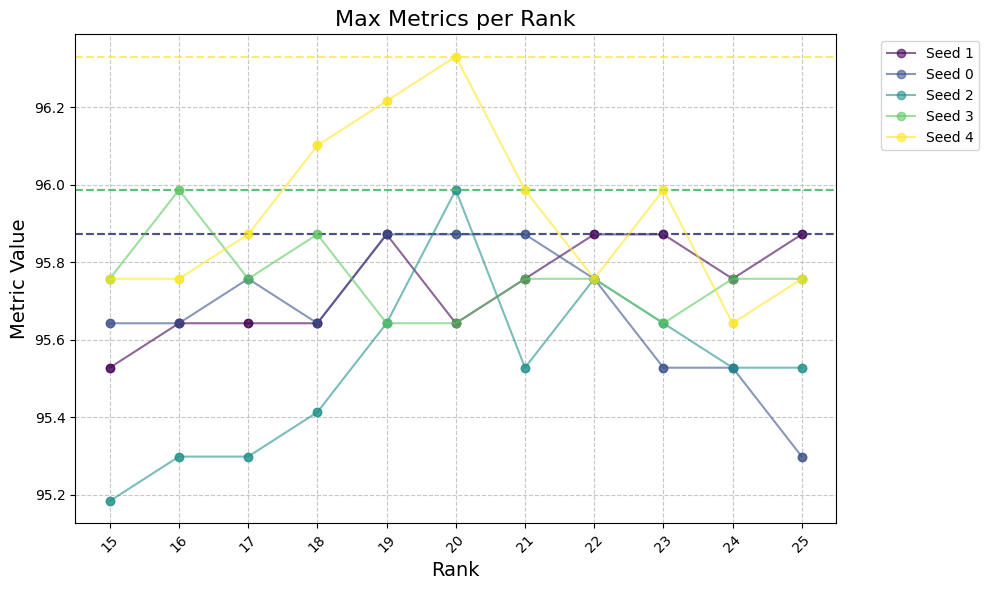

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
all_ranks = set()
for result in run_max_metrics:
    all_ranks.update(result["max_per_rank"].keys())

rank_labels = sorted([int(rank.split("_")[1]) for rank in all_ranks])
colors = cm.viridis(np.linspace(0, 1, len(rank_labels)))
rank_color_map = {rank: color for rank, color in zip(rank_labels, colors)}

fig, ax = plt.subplots(figsize=(10, 6))

for result in run_max_metrics:
    seed = result["seed"]
    max_per_rank = result["max_per_rank"]
    overall_max = result["overall_max"][1]
    
    x_values = [int(rank.split("_")[1]) for rank in max_per_rank.keys()]
    y_values = list(max_per_rank.values())
    
    run_color = cm.viridis(np.linspace(0, 1, len(run_max_metrics)))[run_max_metrics.index(result)]

    for x, y in zip(x_values, y_values):
        ax.scatter(x, y, color=run_color, alpha=0.6)  
    
    ax.plot(
        x_values,
        y_values,
        marker="o",
        label=f"Seed {seed}",  
        color=run_color,  
        alpha=0.6,
    )
    
    ax.axhline(y=overall_max, color=run_color, linestyle='--', alpha=0.7, label='Overall max')

ax.set_title("Max Metrics per Rank", fontsize=16)
ax.set_xlabel("Rank", fontsize=14)
ax.set_ylabel("Metric Value", fontsize=14)

ax.set_xticks(rank_labels)
ax.set_xticklabels(rank_labels)

handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*[(h, l) for h, l in zip(handles, labels) if "Seed" in l])
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
wandb.init(project=project, entity=entity, name="Max Metrics Plot Report")
plot_filename = "max_metrics_per_rank.png"
plt.savefig(plot_filename)

# Log the plot to WandB
wandb.log({"Max Metrics per Rank Plot": wandb.Image(plot_filename)})

# Optionally, show the plot
plt.show()

# Finish the WandB run
wandb.finish()

<Figure size 640x480 with 0 Axes>